# Face Detection and Emotion Analysis with ESP32CAM

In [7]:
#!pip install opencv-python

In [1]:
import cv2

In [2]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')

In [3]:
def detect_face(frame):
    
    gray= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  
    face_rectangle = face_cascade.detectMultiScale(gray,1.3,5) 
    
    for (x,y,w,h) in face_rectangle: 
        cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), 2) 
        
    return frame
    

In [8]:
cap = cv2.VideoCapture("http://192.168.0.112:81/stream") 

while True:
    # Ler o frame do stream
    ret, frame = cap.read()
    if not ret:
        print("Falha ao capturar vídeo do ESP32-CAM")
        break

    # Redimensionar o frame para melhorar o desempenho
    frame_resized = cv2.resize(frame, (640, 480))

    # Converter para escala de cinza (necessário para Haar Cascade)
    gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)

    # Detectar rostos
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Desenhar retângulos ao redor dos rostos
    for (x, y, w, h) in faces:
        cv2.rectangle(frame_resized, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Exibir o vídeo redimensionado com a detecção
    cv2.imshow('ESP32-CAM - Detecção de Rosto', frame_resized)

    # Encerrar com a tecla 'q'
    if cv2.waitKey(0):
        break

# Liberar recursos
cap.release()
cv2.destroyAllWindows()

In [8]:
#!pip install deepface opencv-python

In [9]:
import cv2
from deepface import DeepFace

# Endereço do ESP32-CAM
esp32_url = 'http://192.168.0.112:81/stream'

# Iniciar a captura de vídeo do ESP32-CAM
cap = cv2.VideoCapture(esp32_url)

while True:
    # Ler o frame do stream
    ret, frame = cap.read()
    if not ret:
        print("Falha ao capturar vídeo do ESP32-CAM")
        break
    
       # Redimensionar o frame para melhorar o desempenho
    frame_resized = cv2.resize(frame, (640, 480))  # Ajuste conforme necessário

    try:
        # Analisar expressões faciais usando DeepFace
        analysis = DeepFace.analyze(frame, actions=['emotion'], enforce_detection=False)

        # Obter a emoção predominante (ajuste para a estrutura da saída)
        emotion = analysis[0]['dominant_emotion']

        # Exibir a emoção no frame
        cv2.putText(frame, f'Emocao: {emotion}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    except Exception as e:
        print(f"Erro na análise: {e}")

    # Exibir o vídeo com a emoção detectada
    cv2.imshow('Expressao Facial - ESP32-CAM', frame)

    # Encerrar com a tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar recursos
cap.release()
cv2.destroyAllWindows()


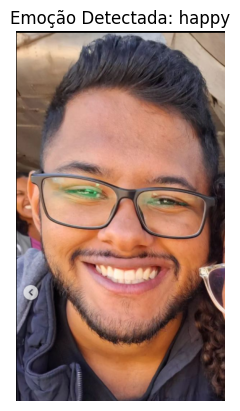

In [7]:
import cv2
from deepface import DeepFace
import matplotlib.pyplot as plt

# Caminho da imagem estática
image_path = 'refereencia.png'  # Substitua pelo caminho da sua imagem

# Carregar a imagem
image = cv2.imread(image_path)

# Converter a imagem de BGR (OpenCV) para RGB (Matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Analisar expressões faciais usando DeepFace
analysis = DeepFace.analyze(image, actions=['emotion'], enforce_detection=False)

# Obter a emoção predominante
emotion = analysis[0]['dominant_emotion']

# Exibir a imagem com a emoção detectada usando Matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Desliga os eixos
plt.title(f'Emoção Detectada: {emotion}')
plt.show()


In [10]:
import cv2
from deepface import DeepFace

# Endereço do ESP32-CAM
esp32_url = 'http://192.168.0.112:81/stream'

# Imagem de referência para comparação (caminho para a imagem)
reference_image_path = 'refereencia.png'

# Gerar embeddings da imagem de referência
reference_embedding = DeepFace.represent(reference_image_path, model_name='VGG-Face')[0]['embedding']

# Iniciar a captura de vídeo do ESP32-CAM
cap = cv2.VideoCapture(esp32_url)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Falha ao capturar vídeo do ESP32-CAM")
        break

    frame_resized = cv2.resize(frame, (640, 480))
    gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)

    # Detectar rostos
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    for (x, y, w, h) in faces:
        face_roi = frame_resized[y:y+h, x:x+w]  # Região de Interesse (ROI)

        try:
            # Gerar o embedding do rosto detectado
            detected_embedding = DeepFace.represent(face_roi, model_name='VGG-Face',enforce_detection=False)[0]['embedding']
            
            # Comparar o embedding do rosto detectado com o embedding da imagem de referência
            similarity = DeepFace.verify(face_roi, reference_image_path, model_name='VGG-Face',enforce_detection=False)['distance']

            # Exibir a semelhança
            cv2.putText(frame_resized, f'Semelhança: {similarity:.2f}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

            # Desenhar o retângulo ao redor do rosto
            cv2.rectangle(frame_resized, (x, y), (x+w, y+h), (255, 0, 0), 2)

        except Exception as e:
            print(f"Erro na análise: {e}")

    # Exibir o vídeo com a semelhança do rosto
    cv2.imshow('Comparação de Rostos - ESP32-CAM', frame_resized)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
